# The MNIST dataset

In [171]:
import mxnet as mx
from mxnet import nd,autograd
import numpy as np

import matplotlib.pyplot as plt

ctx = mx.cpu()

def transform(data,label):
    return data.astype(np.float32)/255, label.astype(np.float32)

mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

# Load the data iterator

(28, 28, 1)


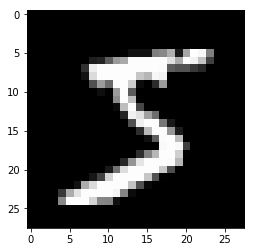

(64, 28, 28, 1)
(64, 784)
(64,)


In [172]:
num_inputs = 784
num_outputs = 10

image,label = mnist_train[0]
#print(image.shape,label)
#print(type(image))
print(image.shape)

import matplotlib.pyplot as plt

#tile:Repeats the whole array multiple times.
image = mx.nd.tile(image,(1,1,3))
plt.imshow(image.asnumpy())
plt.show()

batch_size = 64

train_data = mx.gluon.data.DataLoader(mnist_train,batch_size,shuffle=True)
test_data = mx.gluon.data.DataLoader(mnist_test,batch_size,shuffle=False)


for i,(data,label) in enumerate(train_data):
    print(data.shape)
    print(data.reshape((-1,784)).shape)
    print(label.shape)
    break


    

# allocate model parameter

In [173]:
W = nd.random_normal(shape=(num_inputs,num_outputs),ctx=ctx)
b = nd.random_normal(shape=num_outputs,ctx=ctx)

params = [W,b]

print(W.shape)
print(b.shape)

for param in params:
    param.attach_grad()

(784, 10)
(10,)


# Multiclass logistic regression

In [174]:
def softmax(y_linear):
    exp = nd.exp(y_linear - nd.max(y_linear))
    norms = nd.sum(exp,axis=0,exclude=True).reshape((-1,1))
    return exp / norms

sample_y_linear = nd.random_normal(shape=(2,10))
sample_y_that = softmax(sample_y_linear)
print(sample_y_that)

print(nd.sum(sample_y_that,axis=1))


[[ 0.38545385  0.01461213  0.21097301  0.09367403  0.06165106  0.03282055
   0.05355271  0.01129622  0.04906066  0.08690578]
 [ 0.01336424  0.1757054   0.03210324  0.00211555  0.06595064  0.53959328
   0.06129301  0.0652498   0.02547759  0.01914723]]
<NDArray 2x10 @cpu(0)>

[ 1.          0.99999994]
<NDArray 2 @cpu(0)>


In [139]:
#sum ex
ndarray = nd.arange(6).reshape((2,3))
print(ndarray)

print(nd.sum(ndarray,axis=0))

#nd.sum(ndarray,axis=1).reshape((-1,1))
# exclude 让 axis =1变成 axis =0
nd.sum(ndarray,axis=0,exclude=True).reshape((-1,1))


[[ 0.  1.  2.]
 [ 3.  4.  5.]]
<NDArray 2x3 @cpu(0)>

[ 3.  5.  7.]
<NDArray 3 @cpu(0)>



[[  3.]
 [ 12.]]
<NDArray 2x1 @cpu(0)>

# Define the model

In [175]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    
    return yhat

In [177]:
for i,(data,label) in enumerate(train_data):
    data = data.as_in_context(ctx).reshape((-1,784))
    print(data.shape)
    print(W.shape)
    y_res = nd.dot(data, W) 
    print(y_res.shape)
    break

'''
for i,(data,label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        net(data)
        break
'''

(64, 784)
(784, 10)
(64, 10)


'\nfor i,(data,label) in enumerate(train_data):\n        data = data.as_in_context(ctx).reshape((-1,784))\n        net(data)\n        break\n'

In [83]:
W1 = nd.array([1,2])
X1 = nd.array([[3],[4]])
print(W1)
print(X1)
#nd.dot(X,W)  --error
nd.dot(W1,X1)




[ 1.  2.]
<NDArray 2 @cpu(0)>

[[ 3.]
 [ 4.]]
<NDArray 2x1 @cpu(0)>



[ 11.]
<NDArray 1 @cpu(0)>

# Define the cross-entropy function

[关于交叉熵的详细讲解](http://blog.csdn.net/rtygbwwwerr/article/details/50778098)

In [183]:

def crosss_entroy(yhat,y):
    return -nd.sum(y * nd.log(yhat),axis=0,exclude=True)


# Optimizer

In [179]:
def SGD(params,lr):
    for param in params:
        param[:] = param - lr * param.grad

# Write the evaluation loop to calculate accuracy 

[one hot 详细讲解](https://yq.aliyun.com/articles/126741)

In [180]:
def evaluate_accuracy(data_iterator,net):
    numerator = 0
    denominator = 0
    for i,(data,label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label,10)
        output = net(data)
        predictions = nd.argmax(output,axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        
    return (numerator / denominator).asscalar()

#evaluate_accuracy(test_data,net)

In [181]:
for i,(data,label) in enumerate(test_data):
    data = data.reshape((-1,784))
    print(type(data))
    print(data.shape)
    print(label.shape)
    
    #one_hot 
    label_one_hot = nd.one_hot(label,10)
    print(label_one_hot.shape)
    break
    

<class 'mxnet.ndarray.ndarray.NDArray'>
(64, 784)
(64,)
(64, 10)


# Execute training loop

In [185]:
epochs = 10
moving_loss = 0.
learning_rate = .001
smoothing_constant = .01
niter=0


for e in range(epochs):
    for i,(data,label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label,10)
        with autograd.record():
            output = net(data)
            loss = crosss_entroy(output,label_one_hot)
            
        loss.backward()
        SGD(params,learning_rate)
        
        niter +=1
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        
    test_accuracy = evaluate_accuracy(test_data,net)
    train_accuracy = evaluate_accuracy(train_data,net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, est_loss, train_accuracy, test_accuracy))    
        
    

Epoch 0. Loss: 0.960755664217, Train_acc 0.812667, Test_acc 0.8173
Epoch 1. Loss: 0.803973543784, Train_acc 0.83525, Test_acc 0.8385
Epoch 2. Loss: 0.671597127549, Train_acc 0.84885, Test_acc 0.8515
Epoch 3. Loss: 0.634403980183, Train_acc 0.858017, Test_acc 0.8596
Epoch 4. Loss: 0.605101995557, Train_acc 0.864617, Test_acc 0.8668
Epoch 5. Loss: 0.611256889219, Train_acc 0.870583, Test_acc 0.8719
Epoch 6. Loss: 0.558236088567, Train_acc 0.8747, Test_acc 0.8752
Epoch 7. Loss: 0.533684758549, Train_acc 0.877067, Test_acc 0.8777
Epoch 8. Loss: 0.536125441894, Train_acc 0.880567, Test_acc 0.8801
Epoch 9. Loss: 0.487528433936, Train_acc 0.884117, Test_acc 0.8828


# Using the model for prediction 

(10, 28, 28, 1)


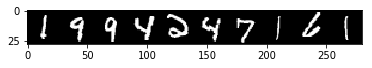

model predictions are: 
[ 1.  9.  9.  4.  2.  4.  7.  1.  6.  1.]
<NDArray 10 @cpu(0)>


In [187]:
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output,axis=1)

sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break
    